The University of Melbourne, School of Computing and Information Systems

# COMP30027 Machine Learning, 2024 Semester 1
## Project 2: IMDB Movie Rating Prediction

The goal of this project is to build and critically analyze supervised machine learning methods for predicting IMDB movie ratings based on various predictor variables that include movie-title, duration, director and actor(s) names and facebook likes, keywords, genre, country, budget, and others. There are five possible outcomes 0 being the lowest and 4 being the highest.

This assignment aims to reinforce the largely theoretical lecture concepts surrounding data representation, classifier construction, evaluation and error analysis, by applying them to an open-ended problem. You will also have an opportunity to practice your general problem-solving skills, written communication skills, and critical thinking skills

# Imports


In [352]:
import pandas as pd
import numpy as np
from collections import Counter
from tqdm import tqdm

# stop words
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

# general
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import TruncatedSVD
from sklearn.utils import resample
from sklearn.ensemble import VotingClassifier, StackingClassifier
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA

# classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, LogisticRegression

# visualisation
import seaborn as sns
from sklearn import tree
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /Users/jason/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jason/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Read data into Dataframes


In [376]:
# Read training and testing dataset into dataframes
train_df = pd.read_csv("project_data/train_dataset.csv")
test_df = pd.read_csv("project_data/test_dataset.csv")

original_columns = list(train_df.columns)
original_numerical = train_df.select_dtypes(include=['int', 'float']).columns

# Feature Engineering 

In [377]:

# Load the features from the .npy files
train_doc2vec_features_plot_keywords = np.load('project_data/features_doc2vec/train_doc2vec_features_plot_keywords.npy')
train_doc2vec_features_genre = np.load('project_data/features_doc2vec/train_doc2vec_features_genre.npy')

test_doc2vec_features_plot_keywords = np.load('project_data/features_doc2vec/test_doc2vec_features_plot_keywords.npy')
test_doc2vec_features_genre = np.load('project_data/features_doc2vec/test_doc2vec_features_genre.npy')

# Convert features to strings and assign them to DataFrame columns
train_df['plot_keywords'] = [str(feature) for feature in train_doc2vec_features_plot_keywords]
train_df['genres'] = [str(feature) for feature in train_doc2vec_features_genre]

test_df['plot_keywords'] = [str(feature) for feature in test_doc2vec_features_plot_keywords]
test_df['genres'] = [str(feature) for feature in test_doc2vec_features_genre]

# Convert genres to individual columns (OneHotEncoding)
# genre_dummies = train_df['genres'].str.get_dummies(sep='|')
# genre_dummies.drop(columns='Film-Noir', inplace=True)         # Only occurs once
# train_df = pd.concat([train_df, genre_dummies], axis=1)
# train_df.drop(columns='genres', inplace=True)

# genre_dummies_test = test_df['genres'].str.get_dummies(sep='|')
# test_df = pd.concat([test_df, genre_dummies_test], axis=1)
# test_df.drop(columns='genres', inplace=True)

# Drop title_embeddings (not sure how to interpret FastText)
# if 'title_embedding' in train_df.columns:
#     train_df.drop(columns='title_embedding', inplace=True)

# if 'title_embedding' in test_df.columns:
#     test_df.drop(columns='title_embedding', inplace=True)

# Convert plot_keywords to individual columns (OneHotEncoding)
# num_plots = 50
# top_keywords = train_df['plot_keywords'].str.split('|', expand=True).stack().value_counts().head(num_plots).index

# for keyword in top_keywords:
#     # Train dataframe
#     train_df[keyword] = train_df['plot_keywords'].apply(lambda x: 1 if keyword in x else 0)
#     # Test dataframe
#     test_df[keyword] = test_df['plot_keywords'].apply(lambda x: 1 if keyword in x else 0)

# train_df.drop('plot_keywords', axis=1, inplace=True)
# test_df.drop('plot_keywords', axis=1, inplace=True)

# Replace names that occur less than average with "Other
# Calculate average counts for director and actors 1, 2, and 3
director_counts = train_df['director_name'].value_counts()
actor1_counts = train_df['actor_1_name'].value_counts()
actor2_counts = train_df['actor_2_name'].value_counts()
actor3_counts = train_df['actor_3_name'].value_counts()

director_average_count = np.mean(director_counts)
actor1_average_count = np.mean(actor1_counts)
actor2_average_count = np.mean(actor2_counts)
actor3_average_count = np.mean(actor3_counts)

# Get rare entries
rare_directors = director_counts[director_counts < director_average_count].index
rare_actors1 = actor1_counts[actor1_counts < actor1_average_count].index
rare_actors2 = actor2_counts[actor2_counts < actor2_average_count].index
rare_actors3 = actor3_counts[actor3_counts < actor3_average_count].index

# Replace rare actors with 'Other'
train_df.loc[train_df['director_name'].isin(rare_directors), 'director_name'] = 'Other'
train_df.loc[train_df['actor_1_name'].isin(rare_actors1), 'actor_1_name'] = 'Other'
train_df.loc[train_df['actor_2_name'].isin(rare_actors2), 'actor_2_name'] = 'Other'
train_df.loc[train_df['actor_3_name'].isin(rare_actors3), 'actor_3_name'] = 'Other'

test_df.loc[test_df['director_name'].isin(rare_directors), 'director_name'] = 'Other'
test_df.loc[test_df['actor_1_name'].isin(rare_actors1), 'actor_1_name'] = 'Other'
test_df.loc[test_df['actor_2_name'].isin(rare_actors2), 'actor_2_name'] = 'Other'
test_df.loc[test_df['actor_3_name'].isin(rare_actors3), 'actor_3_name'] = 'Other'

def preprocess_title(title):
    # Convert to lowercase
    title = title.lower()
    # Remove punctuation
    title = title.translate(str.maketrans('', '', string.punctuation))
    # Tokenize the title
    words = title.split()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Join the words back into a string
    preprocessed_title = ' '.join(words)
    return preprocessed_title

# preprocess movie titles
train_df['movie_title'] = train_df['movie_title'].apply(preprocess_title)
test_df['movie_title'] = test_df['movie_title'].apply(preprocess_title)

print(train_df.shape)
print(test_df.shape)
display(train_df.sample(3))

print(train_df.columns)
print(list(train_df.iloc[85]))
print(list(test_df.iloc[53]))
# print(list(train_df.iloc[575]))

(3004, 27)
(752, 26)


,id,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,title_year,actor_2_facebook_likes,movie_facebook_likes,title_embedding,average_degree_centrality,imdb_score_binned
307,308,M. Night Shyamalan,294,106,0,963,Bruce Willis,18000,94999143,[ 4.8149484e-03 8.3510316e-04 -2.0848678e-03 ...,...,1344,English,USA,PG-13,2000,13000,0,[ 1.32072147e-03 -3.71456903e-04 -5.25125593e-...,0.004427,3
2334,2335,Steven Soderbergh,238,122,0,11000,Matt Damon,14000,117144465,[ 0.00316874 -0.00098444 -0.00122843 -0.004425...,...,288,English,USA,PG-13,2007,13000,0,[-4.2093801e-04 -1.3223651e-03 2.3545155e-04 ...,0.004728,2
44,45,Other,78,92,8,129,Other,472,18843314,[-0.00483875 -0.00075773 -0.00379617 0.004323...,...,284,English,USA,PG-13,2006,239,0,[-4.73986566e-03 2.19502393e-03 9.79464035e-...,0.000300,1


Index(['id', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'num_user_for_reviews', 'language', 'country', 'content_rating',
       'title_year', 'actor_2_facebook_likes', 'movie_facebook_likes',
       'title_embedding', 'average_degree_centrality', 'imdb_score_binned'],
      dtype='object')
[86, 'Other', 161, 89, 7, 399, 'Daniella Alonso', 919, 20801344, '[ 1.7134366e-03  1.0985441e-03  4.6544359e-03  4.5100106e-03\n  9.9990657e-04 -2.3948476e-03  4.6087559e-03  3.4730274e-03\n -1.6057905e-03  1.4388878e-03 -2.3066851e-03  3.9560120e-03\n -2.1784005e-03  2.0862265e-04  4.1084513e-03  4.4961623e-03\n -2.9114020e-05 -2.6183878e-03 -1.8725146e-03  3.0553318e-04\n -2.6247636e-03 -2.0507413e-03  4.72

In [378]:
# Separate features and class for training df
train_df = train_df.dropna(how='any') # drop rows with any missing values

X = train_df.drop(columns=["imdb_score_binned"])         
y = train_df["imdb_score_binned"]

# Test dataset only contains features without labels 
X_test = test_df

print(X.shape, X_test.shape)

(3003, 26) (752, 26)


In [379]:
# Define features 
numeric_features = list(X.select_dtypes(include=['int64', 'float64', 'float32']).columns)
name_features = ['director_name', 'actor_2_name', 'actor_1_name', 'actor_3_name']
categorical_features = [col for col in X.select_dtypes(include=['object']).columns if col not in name_features]

print(numeric_features)
print(categorical_features)
print(name_features)

['id', 'num_critic_for_reviews', 'duration', 'director_facebook_likes', 'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross', 'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster', 'num_user_for_reviews', 'title_year', 'actor_2_facebook_likes', 'movie_facebook_likes', 'average_degree_centrality']
['genres', 'movie_title', 'plot_keywords', 'language', 'country', 'content_rating', 'title_embedding']
['director_name', 'actor_2_name', 'actor_1_name', 'actor_3_name']


# Explore Data

In [361]:
print('*'*60)
print("Shape of dataset : ",X.shape)
print('*'*60)
print("NUMERICAL DATA ANALYSIS")
print('*'*60)
print(X.describe().T)
print('*'*60)
print("CATEGORICAL DATA ANALYSIS")
print('*'*60)
print(X.describe(exclude = ['float', 'int64']).T)
print('*'*60)
print("MISSING VALUES")
print('*'*60)
print(X.isnull().sum())
print('*'*60)

************************************************************
Shape of dataset :  (3003, 26)
************************************************************
NUMERICAL DATA ANALYSIS
************************************************************
                            count          mean           std        min  \
id                         3003.0  1.502072e+03  8.671514e+02     1.0000   
num_critic_for_reviews     3003.0  1.656260e+02  1.212712e+02     2.0000   
duration                   3003.0  1.100793e+02  2.191376e+01    37.0000   
director_facebook_likes    3003.0  7.790396e+02  2.991229e+03     0.0000   
actor_3_facebook_likes     3003.0  7.681159e+02  1.902256e+03     0.0000   
actor_1_facebook_likes     3003.0  7.657469e+03  1.649092e+04     0.0000   
gross                      3003.0  5.189374e+07  6.840704e+07   162.0000   
num_voted_users            3003.0  1.049292e+05  1.508749e+05    91.0000   
cast_total_facebook_likes  3003.0  1.139542e+04  2.004699e+04     0.0000   
fa

# Visualise Data

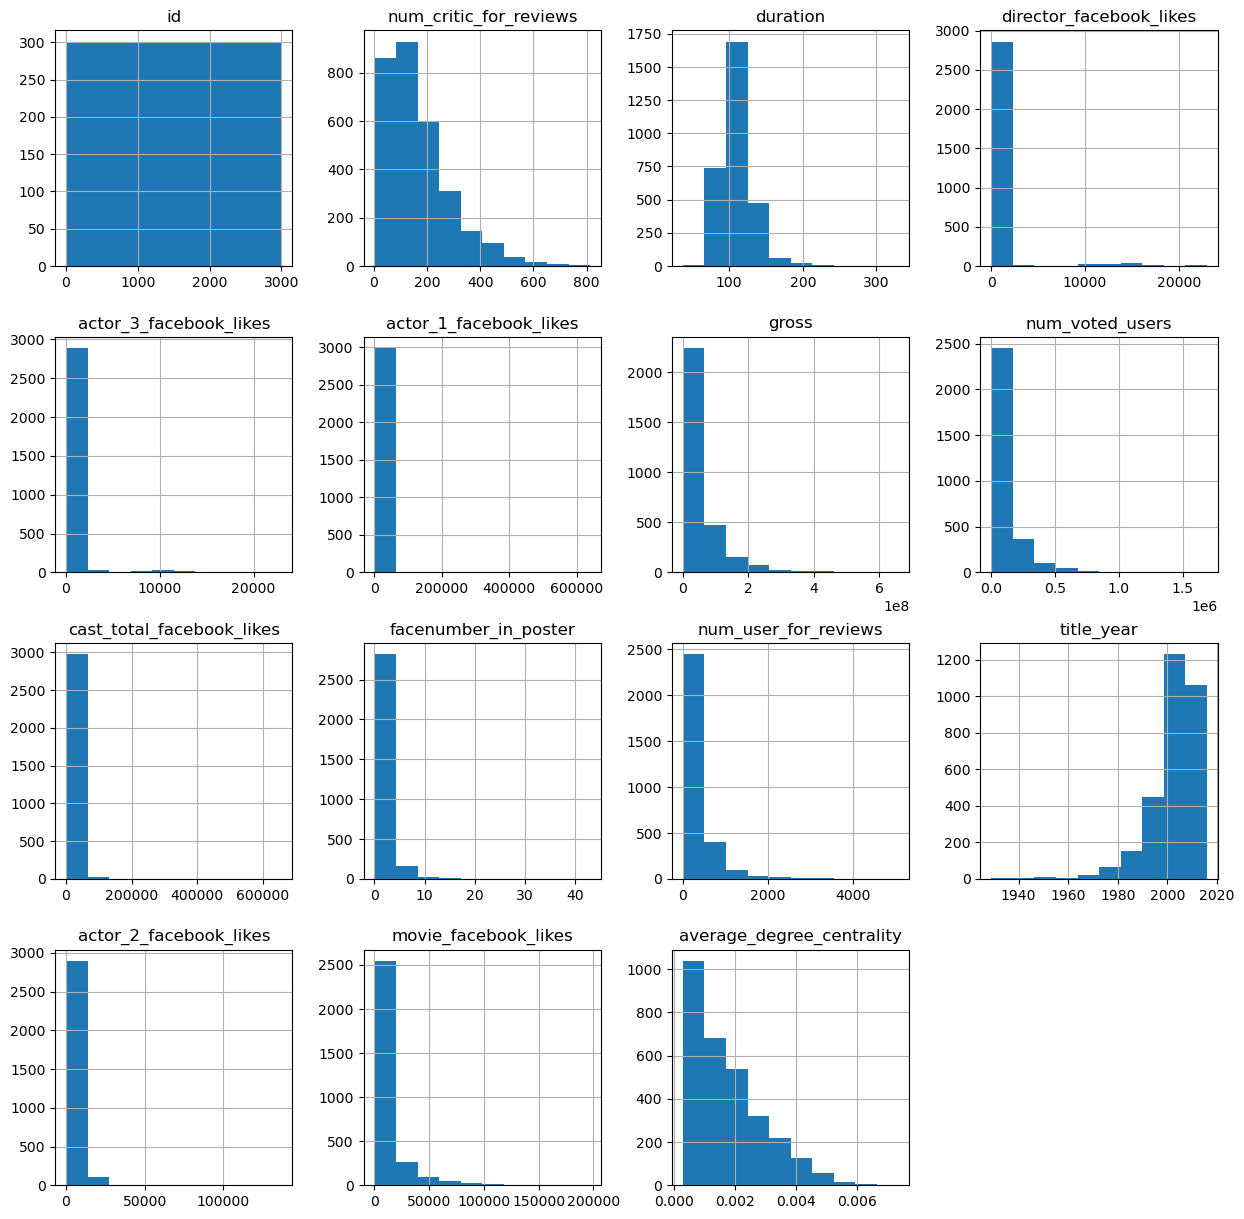

In [277]:
features = ["id", "num_critic_for_reviews", "duration", "director_facebook_likes", "actor_3_facebook_likes", "actor_1_facebook_likes", "gross", "num_voted_users", "cast_total_facebook_likes", "facenumber_in_poster", "num_user_for_reviews", "title_year", "actor_2_facebook_likes", "movie_facebook_likes", "average_degree_centrality"]

histograms = X[features].hist(figsize = [15, 15])
plt.savefig('histograms.png')

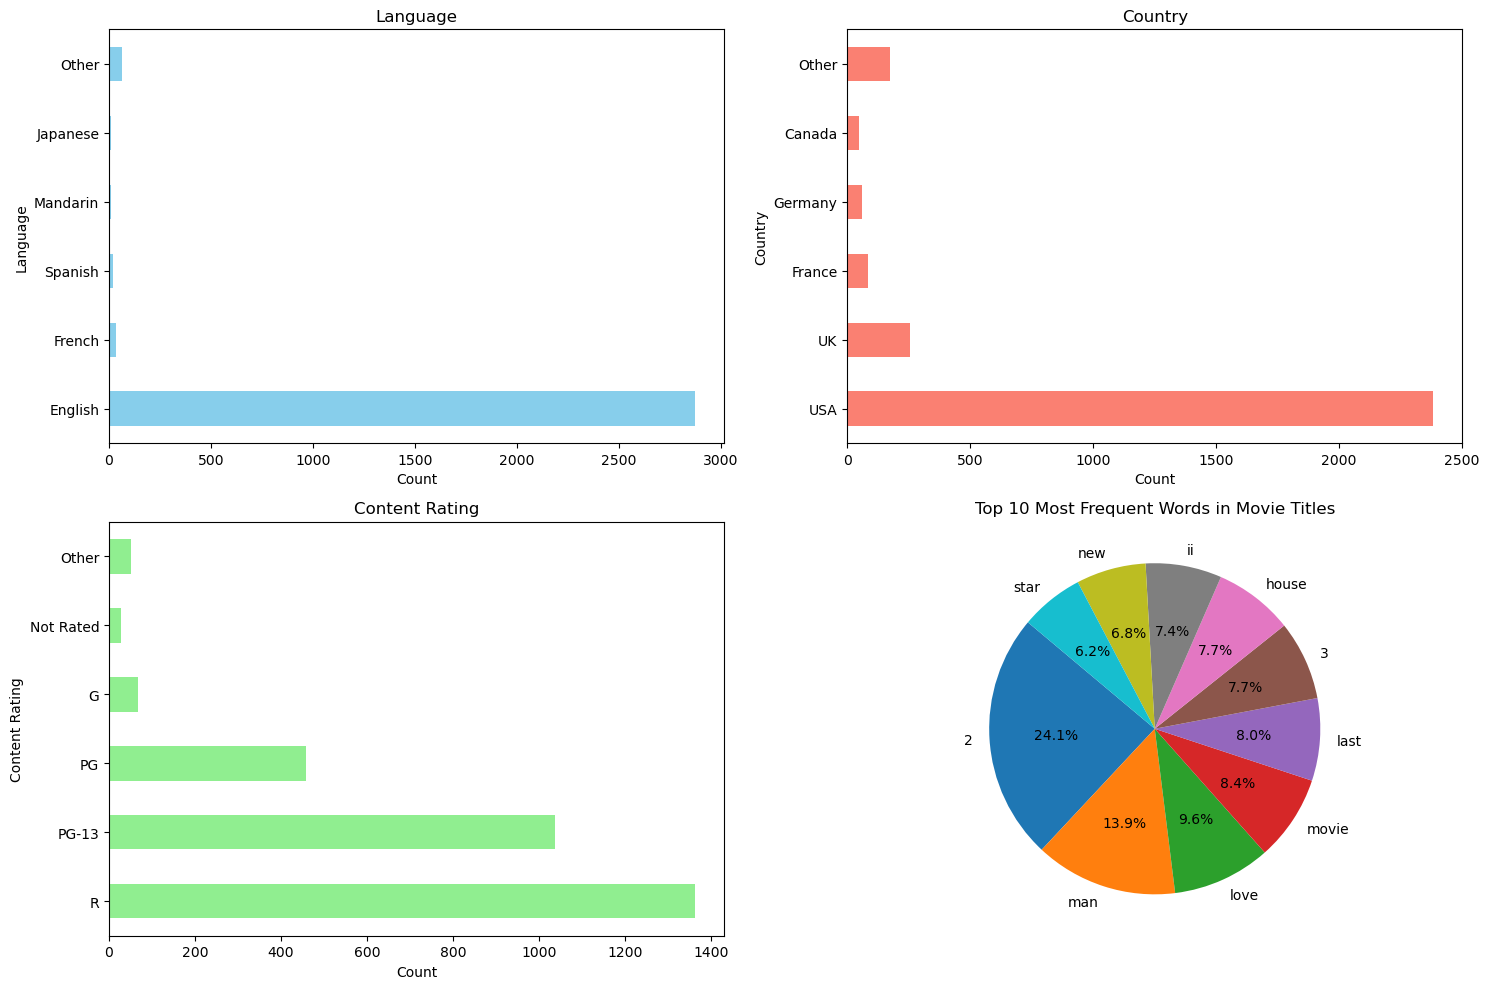

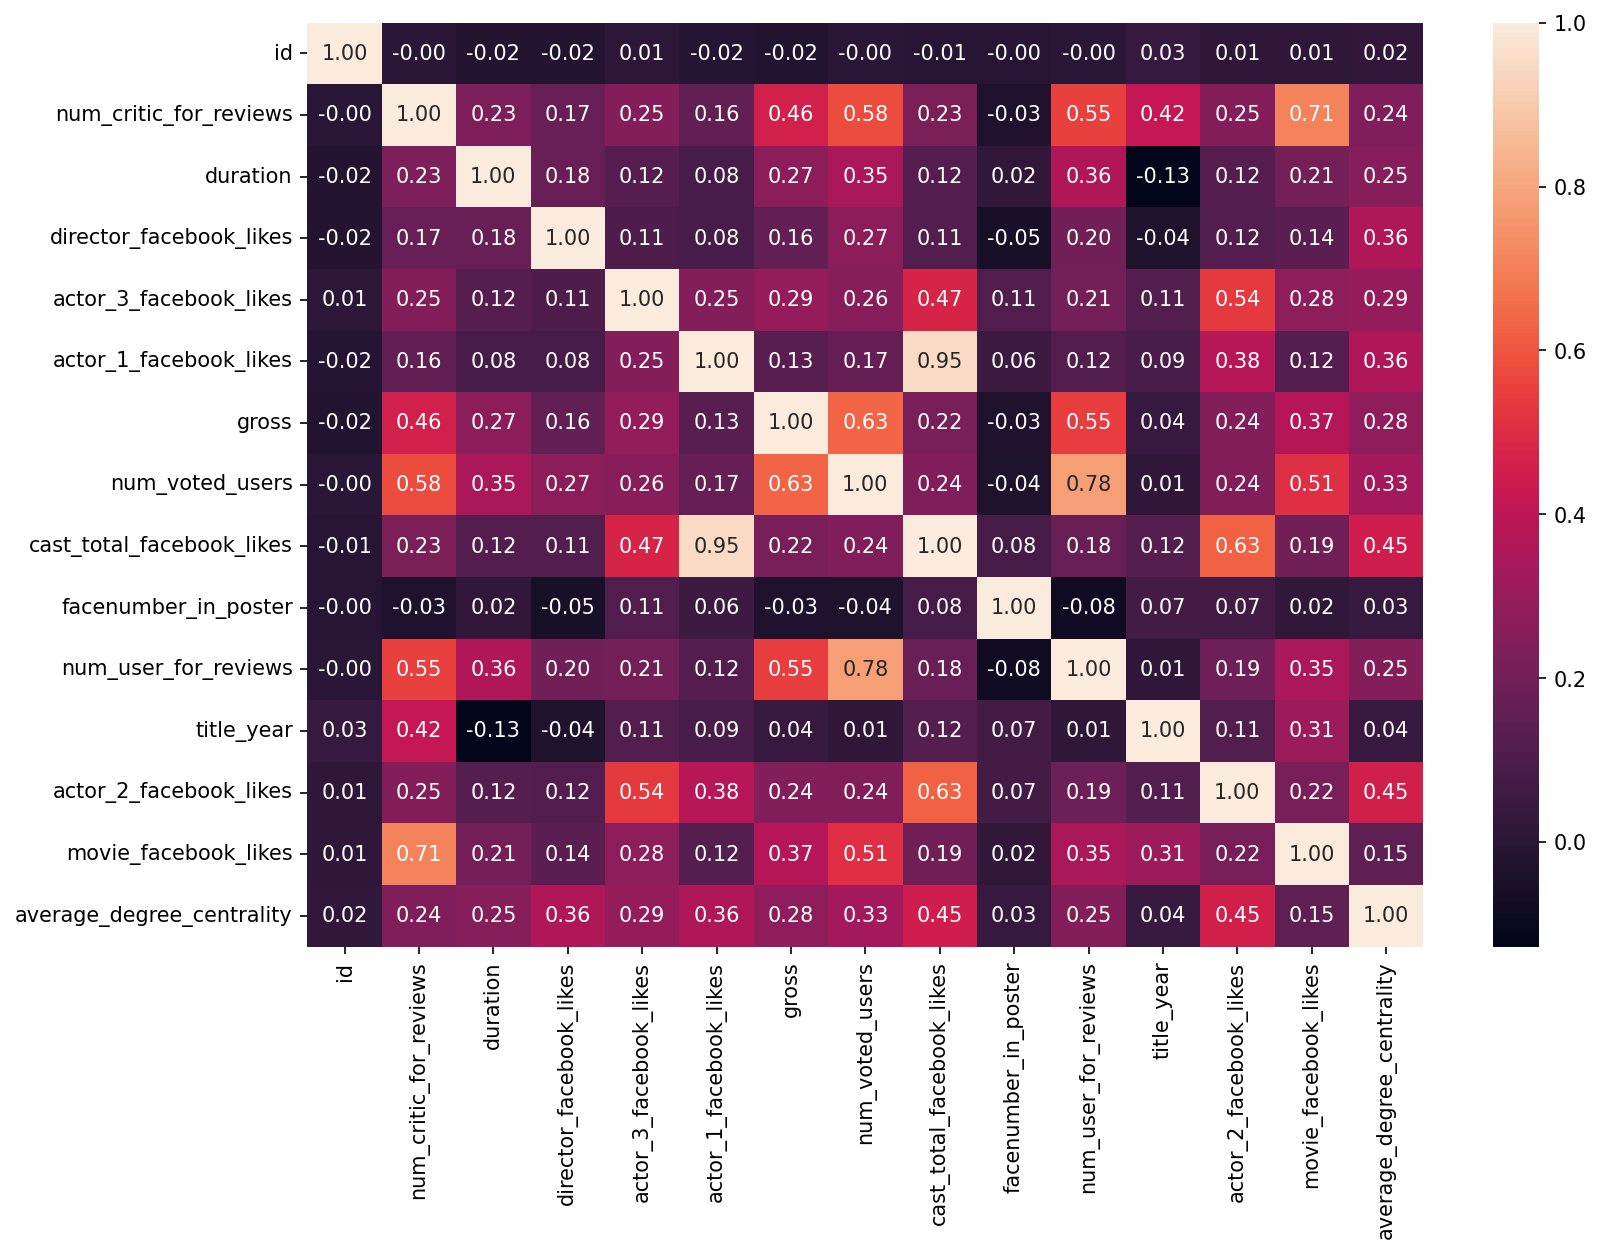

Top 10 Director Counts:


,Director,Count
0,Other,1369
1,Steven Spielberg,21
2,Woody Allen,15
3,Clint Eastwood,15
4,Steven Soderbergh,14
5,Tim Burton,14
6,Spike Lee,12
7,Robert Zemeckis,12
8,Michael Bay,11
9,Wes Craven,11



Top 10 Actor 1 Counts:


,Actor 1,Count
0,Other,1210
1,Johnny Depp,30
2,Robert De Niro,28
3,Harrison Ford,24
4,J.K. Simmons,23
5,Nicolas Cage,23
6,Denzel Washington,23
7,Robert Downey Jr.,22
8,Bruce Willis,22
9,Matt Damon,22



Top 10 Actor 2 Counts:


,Actor 2,Count
0,Other,1331
1,Morgan Freeman,15
2,Charlize Theron,12
3,Judy Greer,9
4,Scott Glenn,8
5,James Franco,8
6,Rosario Dawson,8
7,Will Ferrell,8
8,Thomas Kretschmann,8
9,Meryl Streep,7



Top 10 Actor 3 Counts:


,Actor 3,Count
0,Other,1668
1,Robert Duvall,7
2,Steve Coogan,7
3,Ben Mendelsohn,6
4,Jon Gries,5
5,Gary Oldman,5
6,Bruce McGill,5
7,Cedric the Entertainer,5
8,Craig T. Nelson,5
9,Desmond Llewelyn,5


<Figure size 640x480 with 0 Axes>

In [362]:
#Plotting the categorical variables on the target
plot_data = True

if plot_data:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot horizontal bar plot for language
    language_counts = X['language'].value_counts()
    top_languages = language_counts[:5]  # Display only the top 5 languages
    other_languages_count = language_counts[5:].sum()
    top_languages['Other'] = other_languages_count
    top_languages.plot(kind='barh', ax=axes[0, 0], color='skyblue')
    axes[0, 0].set_title('Language')
    axes[0, 0].set_ylabel('Language')
    axes[0, 0].set_xlabel('Count')

    # Plot horizontal bar plot for country
    country_counts = X['country'].value_counts()
    top_countries = country_counts[:5]  # Display only the top 5 countries
    other_countries_count = country_counts[5:].sum()
    top_countries['Other'] = other_countries_count
    top_countries.plot(kind='barh', ax=axes[0, 1], color='salmon')
    axes[0, 1].set_title('Country')
    axes[0, 1].set_ylabel('Country')
    axes[0, 1].set_xlabel('Count')

    # Plot horizontal bar plot for content rating
    content_rating_counts = X['content_rating'].value_counts()
    top_content_ratings = content_rating_counts[:5]  # Display only the top 5 content ratings
    other_content_rating_count = content_rating_counts[5:].sum()
    top_content_ratings['Other'] = other_content_rating_count
    top_content_ratings.plot(kind='barh', ax=axes[1, 0], color='lightgreen')
    axes[1, 0].set_title('Content Rating')
    axes[1, 0].set_ylabel('Content Rating')
    axes[1, 0].set_xlabel('Count')

    # Plot for title words
    # Flatten the list of lists into a single list of words
    words = X['movie_title'].apply(lambda x: x.split())
    all_words = [word.lower() for title_words in words for word in title_words]
    filtered_unique_words = [word for word in all_words if word.lower() not in stop_words]

    # Count the occurrences of each word
    word_counts = Counter(filtered_unique_words)
    top_words = word_counts.most_common(10)

    # Plot the pie chart
    ax = axes[1, 1]
    ax.pie([count for word, count in top_words], labels=[word for word, count in top_words], autopct='%1.1f%%', startangle=140)
    ax.set_title('Top 10 Most Frequent Words in Movie Titles')

    plt.tight_layout()
    plt.show()

# Correlation HeatMap
plt.figure(figsize=(12,8), dpi=150)
sns.heatmap(X[original_numerical[:-1]].corr(), annot=True, fmt='.2f')

plt.show()
plt.savefig('correlation_heatmap.png')


# Display top 10 names
director_counts = X['director_name'].value_counts().head(10)
actor1_counts = X['actor_1_name'].value_counts().head(10)
actor2_counts = X['actor_2_name'].value_counts().head(10)
actor3_counts = X['actor_3_name'].value_counts().head(10)

director_counts_df = pd.DataFrame({'Director': director_counts.index, 'Count': director_counts.values})
actor1_counts_df = pd.DataFrame({'Actor 1': actor1_counts.index, 'Count': actor1_counts.values})
actor2_counts_df = pd.DataFrame({'Actor 2': actor2_counts.index, 'Count': actor2_counts.values})
actor3_counts_df = pd.DataFrame({'Actor 3': actor3_counts.index, 'Count': actor3_counts.values})

# Display DataFrames
print("Top 10 Director Counts:")
display(director_counts_df)

print("\nTop 10 Actor 1 Counts:")
display(actor1_counts_df)

print("\nTop 10 Actor 2 Counts:")
display(actor2_counts_df)

print("\nTop 10 Actor 3 Counts:")
display(actor3_counts_df)



# Doc2Vec

In [363]:
# Doc2Vec Encoder for categorical data -> numerical
class Doc2VecEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, vector_size=100, min_count=2, epochs=20):
        self.vector_size = vector_size
        self.min_count = min_count
        self.epochs = epochs
        self.model = None

    def fit(self, X, y=None):
        tagged_data = [TaggedDocument(words=doc.split(), tags=[str(i)]) for i, doc in enumerate(X)]
        self.model = Doc2Vec(vector_size=self.vector_size, min_count=self.min_count)
        self.model.build_vocab(tagged_data)
        self.model.train(tagged_data, total_examples=self.model.corpus_count, epochs=self.epochs)
        return self

    def transform(self, X):
        encoded_vectors = []
        for doc in X:
            vector = self.model.infer_vector(doc.split())
            encoded_vectors.append(vector)
        return encoded_vectors


In [75]:
# # Update all categorical features -> numeric (doc2vec)
# fitted_encoders = {}
# remaining_cat_features = ['plot_keywords']

# for feature in remaining_cat_features:
#     doc2vec_encoder = Doc2VecEncoder(vector_size=100, min_count=2, epochs=20)
#     encoded_categorical_features = doc2vec_encoder.fit_transform(X[feature])

#     X[feature] = [str(feature) for feature in encoded_categorical_features]

#     # Store the fitted encoder for later use
#     fitted_encoders[feature] = doc2vec_encoder


# # Transform Testing Data using the fitted encoders from the training data
# for feature in remaining_cat_features:
#     # Retrieve the fitted encoder for the current feature
#     doc2vec_encoder = fitted_encoders[feature]
    
#     # Transform the testing data using the fitted encoder
#     encoded_categorical_features_test = doc2vec_encoder.transform(X_test[feature])

#     X_test[feature] = [str(feature) for feature in encoded_categorical_features_test]


In [279]:
print(X.shape)
display(X.head(3))

print(list(X.iloc[0]))

(3003, 26)


,id,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,plot_keywords,num_user_for_reviews,language,country,content_rating,title_year,actor_2_facebook_likes,movie_facebook_likes,title_embedding,average_degree_centrality
0,1,Roger Allers,186,73,28,847,Nathan Lane,2000,422783777,[ 3.07836081e-03 -1.64460740e-03 9.62910999e-...,...,[-2.8004851e-03 -4.9558324e-03 2.1633205e-03 ...,656,English,USA,G,1994,886,17000,[-4.1984697e-03 4.2941985e-03 -1.1961063e-03 ...,0.001576
1,2,George A. Romero,252,97,0,233,Shawn Roberts,654,20433940,[ 1.7510699e-03 1.0498457e-03 4.6066162e-03 ...,...,[ 2.1234737e-03 2.8782903e-04 -3.0201089e-03 ...,662,English,Canada,R,2005,529,0,[-4.7586653e-03 2.6511205e-03 -3.7954253e-04 ...,0.000675
2,3,David Gordon Green,232,117,234,221,Tye Sheridan,12000,371897,[-3.02969874e-03 -3.05648567e-03 -3.52535793e-...,...,[-2.2412431e-03 -5.2519789e-04 3.6425258e-03 ...,118,English,USA,R,2013,1000,11000,[ 2.78131524e-03 -3.15494463e-03 -6.38332494e-...,0.003002


[1, 'Roger Allers', 186, 73, 28, 847, 'Nathan Lane', 2000, 422783777, '[ 3.07836081e-03 -1.64460740e-03  9.62910999e-04  4.44735494e-03\n -4.52942122e-03 -4.47254116e-03  3.90910171e-03  4.56397049e-03\n  3.79394926e-03  3.42316413e-03  3.75650311e-03 -2.66377395e-03\n -3.54765495e-03  2.62132357e-03  1.80677045e-03 -1.21755886e-03\n -6.45186810e-04  6.28290931e-04  2.24034232e-03  2.17717513e-03\n -4.19147778e-03  3.50303878e-03 -4.30238573e-03  4.93746810e-03\n -1.20570755e-03 -2.43735150e-03 -2.16028281e-03 -3.98806093e-04\n -2.49748002e-03  5.51400881e-04 -3.98165081e-03 -3.75993387e-03\n  3.53019126e-03  2.75408686e-03  1.39351329e-03 -6.99899159e-04\n -5.68542979e-04 -3.99246439e-03  2.37133005e-03  3.66417598e-03\n  1.19924895e-04  2.01272801e-03 -3.03768483e-03  6.69728091e-04\n -2.10504886e-03  2.51243589e-03  4.60134493e-03 -7.18749434e-05\n  2.96249613e-03  4.02282574e-04 -2.35637790e-03 -4.71028266e-03\n  4.31767525e-03 -3.11797252e-03 -1.49458856e-03  3.66348634e-03\n  2.1

## Feature Selection (after visualised data)

In [380]:
# drop features with high correlation with others "actor_1_facebook_likes"
# drop features with low variation
#   id, language, ...
# drop all categorical features (successfully vectorised to numerical)
dropped_features = ["id", "actor_1_facebook_likes"] 
                    # 'movie_title', 
                    # 'language', 
                    # 'country', 
                    # 'actor_1_facebook_likes', 
                    # 'actor_2_facebook_likes',
                    # 'actor_3_facebook_likes',
                    # 'num_user_for_reviews'] 

X.drop(columns=dropped_features, inplace=True)   
X_test.drop(columns=dropped_features, inplace = True)              

In [381]:
# Update features 
numeric_features = list(X.select_dtypes(include=['int64', 'float64', 'float32']).columns)
categorical_features = X.select_dtypes(include=['object']).columns
name_features = ['director_name', 'actor_2_name', 'actor_1_name', 'actor_3_name']

categorical_features = [col for col in categorical_features if col not in name_features]

print(numeric_features)
print(categorical_features)
print(name_features)


['num_critic_for_reviews', 'duration', 'director_facebook_likes', 'actor_3_facebook_likes', 'gross', 'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster', 'num_user_for_reviews', 'title_year', 'actor_2_facebook_likes', 'movie_facebook_likes', 'average_degree_centrality']
['genres', 'movie_title', 'plot_keywords', 'language', 'country', 'content_rating', 'title_embedding']
['director_name', 'actor_2_name', 'actor_1_name', 'actor_3_name']


# Data Preprocessor

In [382]:
# Preprocessing for numerical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler())
])

# Preprocessor for categorical strings (embedded vectors)
class StringToFloatTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Parse each string entry into a list of floats
        embeddings = [np.fromstring(embedding.strip('[]'), dtype=float, sep=' ') for embedding in X]
        # Calculate the average embedding for each row
        average_embeddings = [np.mean(embedding) for embedding in embeddings]
        # Return the average embeddings as a single float value for each row
        return np.array(average_embeddings).reshape(-1, 1)

        
embedding_transformer = Pipeline(steps=[
    ('string_to_float', StringToFloatTransformer()),  
    ('scaler', StandardScaler())
])

# Transformers for name features
name_transformers = []
for feature in name_features:
    if feature in X.columns:
        name_transformer = Pipeline(steps=[
            ('vectorizer', TfidfVectorizer())
        ])
        name_transformers.append((feature, name_transformer, feature))

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('genre', embedding_transformer, 'genres'),  
        ('plot', embedding_transformer, 'plot_keywords'),  
        ('title_embeddings', embedding_transformer, 'title_embedding'),  
        ('title', TfidfVectorizer(), 'movie_title'),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['language', 'country', 'content_rating']),
        *name_transformers
    ])

print(X.shape, X_test.shape)
# print(list(OneHotEncoder().fit_transform(X[['director_name']])[:3].toarray()))

X_processed = preprocessor.fit_transform(X)
print("Shape of processed data:", X_processed.shape)
print(list(X_processed[0].toarray()[0]))

(3003, 24) (752, 24)
Shape of processed data: (3003, 6116)
[0.16803122574961968, -1.692335240396953, -0.2511224500801654, 0.041475616336474654, 5.422714190105649, 3.5758675416604624, -0.24633339096138995, -0.6598710471678074, 0.7707017571253835, -0.8706100803451984, -0.23812586875391956, 0.4046801874866986, -0.13791243111231863, 0.8794581829526539, -0.32248813079370764, -2.0780953437518312, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

# Train-Test Split

In [383]:
# Split the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.01)
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.01)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(2972, 24) (2972,)
(31, 24) (31,)


## Distribution of Movie Ratings


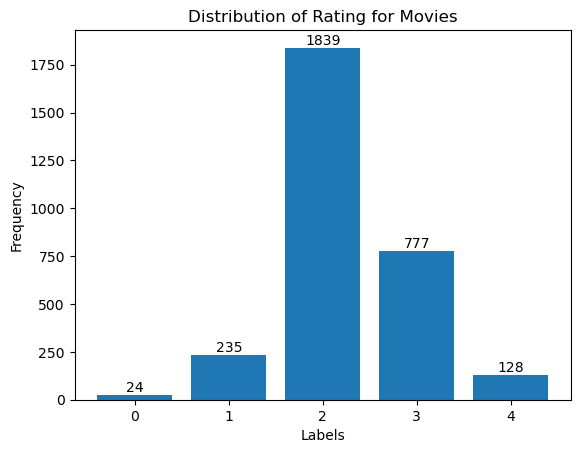

In [384]:
# Plot bar plot of y
counts = np.bincount(y)
plt.bar(range(len(counts)), counts)
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Distribution of Rating for Movies')

# Annotate each bar with its count
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

## Min, Max, Average, Variance

In [385]:
print("Minimum of Ratings:", round(min(y),2))
print("Maximum of Ratings:", round(max(y),2))
print("Average of Ratings:", round(np.mean(y),2))
print("Variance of Ratings:",round(np.var(y),2))

Minimum of Ratings: 0
Maximum of Ratings: 4
Average of Ratings: 2.25
Variance of Ratings: 0.48


## Pair Plot

In [ ]:
# Create a pairplot
pairplot = sns.pairplot(X_train, hue='imdb_score', diag_kind='kde')

# save image
pairplot.savefig('pairplot.png')

## K-NN 

In [388]:
# Feature selection + TruncatedSVD
feature_selection = SelectKBest(score_func=f_classif, k="all")
svd = TruncatedSVD(n_components=100)

# Define the pipeline with preprocessing, feature selection, and KNN classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    # ('svd', svd), 
    ('knn', KNeighborsClassifier(weights='distance'))
])

# Define parameter grid
param_grid = {
    'knn__n_neighbors': [30, 35, 40],
    'knn__metric': ['manhattan', 'cosine'],
}

# Perform grid search with cross-validation
knn_grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy', verbose=2)
knn_grid_search.fit(X_train, y_train)


Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] END .........knn__metric=manhattan, knn__n_neighbors=30; total time=   0.5s
[CV] END .........knn__metric=manhattan, knn__n_neighbors=30; total time=   0.5s
[CV] END .........knn__metric=manhattan, knn__n_neighbors=30; total time=   0.8s
[CV] END .........knn__metric=manhattan, knn__n_neighbors=30; total time=   0.4s
[CV] END .........knn__metric=manhattan, knn__n_neighbors=30; total time=   0.4s
[CV] END .........knn__metric=manhattan, knn__n_neighbors=30; total time=   0.4s
[CV] END .........knn__metric=manhattan, knn__n_neighbors=30; total time=   0.4s
[CV] END .........knn__metric=manhattan, knn__n_neighbors=30; total time=   0.4s
[CV] END .........knn__metric=manhattan, knn__n_neighbors=30; total time=   0.4s
[CV] END .........knn__metric=manhattan, knn__n_neighbors=30; total time=   0.4s
[CV] END .........knn__metric=manhattan, knn__n_neighbors=35; total time=   0.4s
[CV] END .........knn__metric=manhattan, knn__n_

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['num_critic_for_reviews',
                                                                          'duration',
                                                                          'director_facebook_likes',
                                                                          'actor_3_facebook_likes',
                                                                          'gross',
                                                                          'num_voted_users',
                                                                          'cast_total_facebook_likes',
                                                                          'facenumber_in_poster',
                                                                          'num_user_f...
                                                                                          TfidfVectorizer())]),
                                                                         'actor_2_name'),
                                                                        ('actor_1_name',
                                                                         Pipeline(steps=[('vectorizer',
                                                                                          TfidfVectorizer())]),
                                                                         'actor_1_name'),
                                                                        ('actor_3_name',
                                                                         Pipeline(steps=[('vectorizer',
                                                                                          TfidfVectorizer())]),
                                                                         'actor_3_name')])),
                                       ('knn',
                                        KNeighborsClassifier(weights='distance'))]),
             param_grid={'knn__metric': ['manhattan', 'cosine'],
                         'knn__n_neighbors': [30, 35, 40]},
             scoring='accuracy', verbose=2)

In [389]:
# Get the best parameters and best score
best_params = knn_grid_search.best_params_
best_score = knn_grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Evaluate on the validation set using the best model
knn_best_model = knn_grid_search.best_estimator_

# View accuracy
val_accuracy = accuracy_score(y_val, knn_best_model.predict(X_val))
print("Validation Accuracy with Best Model:", val_accuracy)

Best Parameters: {'knn__metric': 'cosine', 'knn__n_neighbors': 30}
Best Score: 0.6810306645877116
Validation Accuracy with Best Model: 0.7096774193548387


### Predict with KNN

In [390]:
# Make predictions on X_test with KNN
predictions = knn_best_model.predict(X_test)

# Create a DataFrame to store the predictions
prediction_df = pd.DataFrame({'id': range(1, len(predictions) + 1), 'imdb_score_binned': predictions})

# Write the predictions to a CSV file
prediction_df.to_csv('knn_predictions.csv', index=False)

## Decision Tree / Random Forest


In [395]:
# Define preprocessing steps
feature_selector = SelectKBest(score_func=f_classif, k=100)  
classifier = RandomForestClassifier(n_estimators=200, 
                                    max_features='sqrt',
                                    bootstrap=True,
                                    class_weight='balanced',
                                    max_depth=None)

# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    # ('feature_selector', feature_selector),
    ('classifier', classifier)
])

# Define parameter grid
param_grid = {
    'classifier__min_samples_split': [2, 5],
}

# Perform grid search with cross-validation
rf_grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy', verbose=2)
rf_grid_search.fit(X_train, y_train)


Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV] END ....................classifier__min_samples_split=2; total time=   5.6s
[CV] END ....................classifier__min_samples_split=2; total time=   5.5s
[CV] END ....................classifier__min_samples_split=2; total time=   5.3s
[CV] END ....................classifier__min_samples_split=2; total time=   5.4s
[CV] END ....................classifier__min_samples_split=2; total time=   5.3s
[CV] END ....................classifier__min_samples_split=2; total time=   5.6s
[CV] END ....................classifier__min_samples_split=2; total time=   5.6s
[CV] END ....................classifier__min_samples_split=2; total time=   7.2s
[CV] END ....................classifier__min_samples_split=2; total time=   5.7s
[CV] END ....................classifier__min_samples_split=2; total time=   6.0s
[CV] END ....................classifier__min_samples_split=5; total time=   4.2s
[CV] END ....................classifier__min_sam

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['num_critic_for_reviews',
                                                                          'duration',
                                                                          'director_facebook_likes',
                                                                          'actor_3_facebook_likes',
                                                                          'gross',
                                                                          'num_voted_users',
                                                                          'cast_total_facebook_likes',
                                                                          'facenumber_in_poster',
                                                                          'num_user_f...
                                                                                          TfidfVectorizer())]),
                                                                         'actor_2_name'),
                                                                        ('actor_1_name',
                                                                         Pipeline(steps=[('vectorizer',
                                                                                          TfidfVectorizer())]),
                                                                         'actor_1_name'),
                                                                        ('actor_3_name',
                                                                         Pipeline(steps=[('vectorizer',
                                                                                          TfidfVectorizer())]),
                                                                         'actor_3_name')])),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_estimators=200))]),
             param_grid={'classifier__min_samples_split': [2, 5]},
             scoring='accuracy', verbose=2)

In [396]:
# Get the best parameters and best score
best_params = rf_grid_search.best_params_
best_score = rf_grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Evaluate on the validation set using the best model
rf_best_model = rf_grid_search.best_estimator_
val_accuracy = rf_best_model.score(X_val, y_val)
print("Validation Accuracy with Best Model:", val_accuracy)

Best Parameters: {'classifier__min_samples_split': 5}
Best Score: 0.6951573904594038
Validation Accuracy with Best Model: 0.7741935483870968


## Predict with Random Forest

In [397]:
# Make predictions on X_test with Random Forest
predictions = rf_best_model.predict(X_test)

# Create a DataFrame to store the predictions
prediction_df = pd.DataFrame({'id': range(1, len(predictions) + 1), 'imdb_score_binned': predictions})

# Write the predictions to a CSV file
prediction_df.to_csv('rf_predictions.csv', index=False)

## SVM


In [417]:
# Define feature selection, imputation, and SVM classifier
feature_selector = SelectKBest(score_func=f_classif, k="all")  
classifier = SVC(gamma='scale')

# Define the pipeline including feature engineering
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    # ('feature_selector', feature_selector),
    ('classifier', classifier)
])

# Define parameter grid
param_grid = {
    'classifier__C': [8, 10, 12]
}

# Perform grid search with cross-validation
svm_grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy', verbose=2)   # Verbose shows comments during search
svm_grid_search.fit(X_train, y_train)


Fitting 10 folds for each of 3 candidates, totalling 30 fits


[CV] END ....................................classifier__C=8; total time=   2.0s
[CV] END ....................................classifier__C=8; total time=   1.5s
[CV] END ....................................classifier__C=8; total time=   1.8s
[CV] END ....................................classifier__C=8; total time=   1.7s
[CV] END ....................................classifier__C=8; total time=   1.8s
[CV] END ....................................classifier__C=8; total time=   1.6s
[CV] END ....................................classifier__C=8; total time=   1.7s
[CV] END ....................................classifier__C=8; total time=   1.6s
[CV] END ....................................classifier__C=8; total time=   1.7s
[CV] END ....................................classifier__C=8; total time=   1.7s
[CV] END ...................................classifier__C=10; total time=   1.7s
[CV] END ...................................classifier__C=10; total time=   1.6s
[CV] END ...................

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['num_critic_for_reviews',
                                                                          'duration',
                                                                          'director_facebook_likes',
                                                                          'actor_3_facebook_likes',
                                                                          'gross',
                                                                          'num_voted_users',
                                                                          'cast_total_facebook_likes',
                                                                          'facenumber_in_poster',
                                                                          'num_user_f...
                                                                         'director_name'),
                                                                        ('actor_2_name',
                                                                         Pipeline(steps=[('vectorizer',
                                                                                          TfidfVectorizer())]),
                                                                         'actor_2_name'),
                                                                        ('actor_1_name',
                                                                         Pipeline(steps=[('vectorizer',
                                                                                          TfidfVectorizer())]),
                                                                         'actor_1_name'),
                                                                        ('actor_3_name',
                                                                         Pipeline(steps=[('vectorizer',
                                                                                          TfidfVectorizer())]),
                                                                         'actor_3_name')])),
                                       ('classifier', SVC())]),
             param_grid={'classifier__C': [8, 10, 12]}, scoring='accuracy',
             verbose=2)

In [418]:
# Get the best parameters and best score
best_params = svm_grid_search.best_params_
best_score = svm_grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Evaluate on the validation set using the best model
svm_best_model = svm_grid_search.best_estimator_
val_accuracy = svm_best_model.score(X_val, y_val)
print("Validation Accuracy with Best Model:", val_accuracy)
print("Classification Report:", classification_report(y_val, svm_best_model.predict(X_val), zero_division=1))


Best Parameters: {'classifier__C': 8}
Best Score: 0.7214030687185049
Validation Accuracy with Best Model: 0.7741935483870968
Classification Report:               precision    recall  f1-score   support

           1       0.67      0.50      0.57         4
           2       0.78      0.90      0.84        20
           3       0.67      0.40      0.50         5
           4       1.00      1.00      1.00         2

    accuracy                           0.77        31
   macro avg       0.78      0.70      0.73        31
weighted avg       0.76      0.77      0.76        31



### Predict with SVM

In [400]:
# Make predictions on X_test with SVM
predictions = svm_best_model.predict(X_test)

# Create a DataFrame to store the predictions
prediction_df = pd.DataFrame({'id': range(1, len(predictions) + 1), 'imdb_score_binned': predictions})

# Write the predictions to a CSV file
prediction_df.to_csv('svm_predictions.csv', index=False)

## SVM Bagging

In [401]:
# BOOTSTRAPPING
# Define the number of bootstrap iterations
n_bootstrap = 50

# Initialize a list to store predictions
bagged_predictions = []

# Perform bootstrap resampling and bagging
for _ in tqdm(range(n_bootstrap), desc='Bootstrapping'):
    # Generate a bootstrap sample (with replacement)
    bootstrap_indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
    X_bootstrap = X_train.iloc[bootstrap_indices]
    y_bootstrap = y_train.iloc[bootstrap_indices]

    # Fit on the bootstrap sample
    svm_grid_search.best_estimator_.fit(X_bootstrap, y_bootstrap)
    
    # Make predictions on X_test with the fitted SVM classifier
    predictions = svm_grid_search.best_estimator_.predict(X_test)
    bagged_predictions.append(predictions)

# Aggregate predictions using majority voting
voting_predictions = []
for i in range(len(X_test)):
    predictions = [bagged_pred[i] for bagged_pred in bagged_predictions]
    majority_prediction = max(set(predictions), key=predictions.count)
    voting_predictions.append(majority_prediction)


Bootstrapping:   0%|          | 0/50 [00:00<?, ?it/s]

Bootstrapping: 100%|██████████| 50/50 [01:26<00:00,  1.73s/it]


In [402]:
# Output predictions to a CSV file
output_df = pd.DataFrame({'id': range(1, len(voting_predictions) + 1), 'imdb_score_binned': voting_predictions})
output_df.to_csv('svm-bagging_predictions.csv', index=False)

## Permutation Feature Importance

In [403]:
# Fit your SVM model (best_model) on the training data
svm_best_model.fit(X_train, y_train)

# Compute baseline performance on the validation set
baseline_score = svm_best_model.score(X_val, y_val)

# Compute permutation feature importance
perm_importance = permutation_importance(svm_best_model, X_val, y_val, n_repeats=10, random_state=42)

# Get feature importances and their names
feature_importances = perm_importance.importances_mean
feature_names = X_val.columns


[('num_voted_users', 0.16774193548387095),
 ('movie_facebook_likes', 0.05483870967741934),
 ('title_year', 0.04193548387096774),
 ('duration', 0.0258064516129032),
 ('facenumber_in_poster', 0.0258064516129032),
 ('country', 0.0258064516129032),
 ('num_critic_for_reviews', 0.022580645161290304),
 ('gross', 0.009677419354838701),
 ('director_facebook_likes', 0.0064516129032258),
 ('cast_total_facebook_likes', 0.0032258064516129),
 ('actor_2_name', 0.0),
 ('plot_keywords', 0.0),
 ('language', 0.0),
 ('num_user_for_reviews', -3.3306690738754695e-17),
 ('movie_title', -0.0032258064516129),
 ('content_rating', -0.0032258064516129115),
 ('actor_1_name', -0.0064516129032258),
 ('genres', -0.009677419354838701),
 ('actor_3_facebook_likes', -0.016129032258064502),
 ('actor_2_facebook_likes', -0.0258064516129032),
 ('average_degree_centrality', -0.025806451612903226),
 ('actor_3_name', -0.029032258064516137),
 ('title_embedding', -0.04193548387096775),
 ('director_name', -0.058064516129032295)]

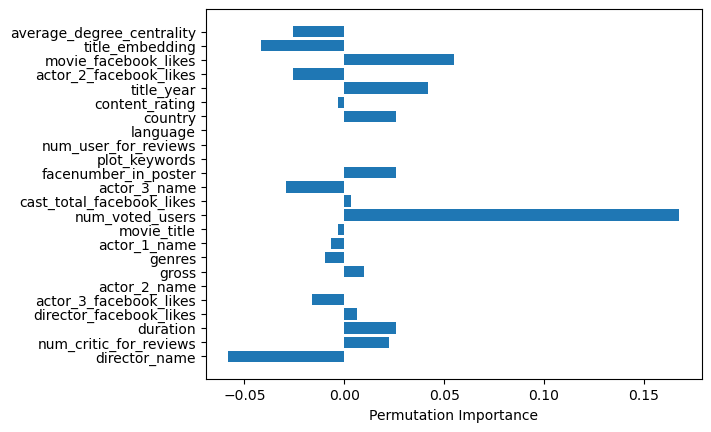

In [404]:

features = zip(feature_names, feature_importances)
sorted_features = sorted(features, key=lambda x: x[1], reverse=True)

display(sorted_features)

# Plot feature importance
plt.barh(feature_names, feature_importances)
plt.xlabel('Permutation Importance')
plt.show()


## Logistic Regression


In [412]:
# Define feature selection and logistic regression classifier
feature_selector = SelectKBest(score_func=f_classif, k=10)
classifier = LogisticRegression(max_iter=1000)  

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    # ('feature_selector', feature_selector),
    ('classifier', classifier)
])

# Define parameter grid
param_grid = {
    'classifier__C': [0.1, 1, 10] 
}

# Perform grid search with cross-validation
logistic_grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy', verbose=2)
logistic_grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[CV] END ..................................classifier__C=0.1; total time=   1.9s
[CV] END ..................................classifier__C=0.1; total time=   1.2s
[CV] END ..................................classifier__C=0.1; total time=   1.2s
[CV] END ..................................classifier__C=0.1; total time=   1.3s
[CV] END ..................................classifier__C=0.1; total time=   1.0s
[CV] END ..................................classifier__C=0.1; total time=   1.5s
[CV] END ..................................classifier__C=0.1; total time=   1.0s
[CV] END ..................................classifier__C=0.1; total time=   1.0s
[CV] END ..................................classifier__C=0.1; total time=   1.3s
[CV] END ..................................classifier__C=0.1; total time=   1.5s
[CV] END ....................................classifier__C=1; total time=   1.9s
[CV] END ....................................classifier__C=1; total time=   2.0s
[CV] END ...................

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['num_critic_for_reviews',
                                                                          'duration',
                                                                          'director_facebook_likes',
                                                                          'actor_3_facebook_likes',
                                                                          'gross',
                                                                          'num_voted_users',
                                                                          'cast_total_facebook_likes',
                                                                          'facenumber_in_poster',
                                                                          'num_user_f...
                                                                         Pipeline(steps=[('vectorizer',
                                                                                          TfidfVectorizer())]),
                                                                         'actor_2_name'),
                                                                        ('actor_1_name',
                                                                         Pipeline(steps=[('vectorizer',
                                                                                          TfidfVectorizer())]),
                                                                         'actor_1_name'),
                                                                        ('actor_3_name',
                                                                         Pipeline(steps=[('vectorizer',
                                                                                          TfidfVectorizer())]),
                                                                         'actor_3_name')])),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'classifier__C': [0.1, 1, 10]}, scoring='accuracy',
             verbose=2)

In [413]:
best_params = logistic_grid_search.best_params_
best_score = logistic_grid_search.best_score_

print(best_params, best_score)

# Get the best model from the grid search
reg_best_model = logistic_grid_search.best_estimator_

# Predictions on validation set
y_pred_val = reg_best_model.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred_val)
print("Accuracy:", accuracy)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_pred_val, zero_division=1))

{'classifier__C': 0.1} 0.70290036833661
Accuracy: 0.7741935483870968
Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.00      0.00         4
           2       0.76      0.95      0.84        20
           3       0.75      0.60      0.67         5
           4       1.00      1.00      1.00         2

    accuracy                           0.77        31
   macro avg       0.88      0.64      0.63        31
weighted avg       0.80      0.77      0.72        31



# Further implement
## Ensemble Method
Stacking or Voting Classifier / Feature engineering / Data processing / Hyperparameter Tuning / Different cross-val

In [98]:
# Define the ensemble model                  
voting_clf = Pipeline([
    ('voting', VotingClassifier(estimators=[
        ('knn', knn_best_model),
        ('reg', reg_best_model),        
        ('rf', rf_best_model),
        ('svm', svm_best_model),
    ], voting='hard', weights = [1, 1, 1, 2]))                   
])

voting_clf.fit(X_train, y_train)

voting_pred = voting_clf.predict(X_val)

# Evaluate the voting classifier
voting_accuracy = accuracy_score(y_val, voting_pred)
print("Voting Classifier Accuracy:", voting_accuracy)
print("Classification Report:", classification_report(y_val, voting_clf.predict(X_val), zero_division=1))

Voting Classifier Accuracy: 0.7342192691029901
Classification Report:               precision    recall  f1-score   support

           0       1.00      0.00      0.00         1
           1       1.00      0.04      0.08        24
           2       0.77      0.91      0.83       196
           3       0.61      0.57      0.59        70
           4       1.00      0.20      0.33        10

    accuracy                           0.73       301
   macro avg       0.87      0.34      0.37       301
weighted avg       0.76      0.73      0.70       301



In [47]:
ensemble_predictions = voting_clf.predict(X_test)

# Create a DataFrame to store the predictions
prediction_df = pd.DataFrame({'id': range(1, len(ensemble_predictions) + 1), 'imdb_score_binned': ensemble_predictions})

# Write the predictions to a CSV file
prediction_df.to_csv('ensemble_predictions.csv', index=False)

In [409]:
base_models = [
    ('svm', svm_best_model),
    ('rf', rf_best_model),
    ('logreg', reg_best_model)
]

stacked_model = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(max_iter=1000) 
)

stacked_model.fit(X_train, y_train)

# Evaluate the stacked model
accuracy = stacked_model.score(X_val, y_val)
print("Stacked Model Accuracy:", accuracy)

stacking_predictions = stacked_model.predict(X_test)

# Create a DataFrame to store the predictions
prediction_df = pd.DataFrame({'id': range(1, len(stacking_predictions) + 1), 'imdb_score_binned': stacking_predictions})

# Write the predictions to a CSV file
prediction_df.to_csv('stacking_predictions.csv', index=False)

Stacked Model Accuracy: 0.8064516129032258


### Compare csv's for different predictions


In [416]:
csv1 = 'svm-bagging_predictions.csv'
csv2 = 'svm_predictions.csv'

df1_name = csv1.split('_')[0]
df2_name = csv2.split('_')[0]

# Read the first CSV file
df1 = pd.read_csv(csv1)

# Read the second CSV file
df2 = pd.read_csv(csv2)

# Compare the two DataFrames
differences = df1.compare(df2)
differences = differences.rename(columns={'self': df1_name, 'other': df2_name})

# Print the differences
print("Differences between", csv1, "and", csv2, "with movie titles:")
print("Number of differences:", len(differences))

movie_titles = pd.read_csv("project_data/test_dataset.csv").loc[differences.index, 'movie_title']
title_years = pd.read_csv("project_data/test_dataset.csv").loc[differences.index, 'title_year']

differences['movie'] = movie_titles
differences['title_year'] = title_years

# Join movie titles to differences DataFrame
display(differences)



Differences between svm-bagging_predictions.csv and svm_predictions.csv with movie titles:
Number of differences: 34


imdb_score_binned                                                   movie  \
          svm-bagging  svm                                                      
1                 2.0  3.0                                           Savages    
23                2.0  3.0                                        Magic Mike    
35                3.0  4.0                                  The Great Beauty    
47                2.0  3.0                                         The Order    
54                2.0  1.0                                 Meet the Spartans    
111               2.0  3.0                               Miracle at St. Anna    
116               2.0  1.0                                        The Unborn    
170               2.0  1.0                                       Left Behind    
183               3.0  4.0                                      A Separation    
184               2.0  3.0                             X-Men: The Last Stand    
188               2.0  3.0                                 A Most Wanted Man    
214               2.0  3.0                                         Celebrity    
239               3.0  2.0                          The Adventures of Tintin    
289               2.0  1.0                           Spy Kids 3-D: Game Over    
302               2.0  3.0                                     Lady in White    
303               2.0  1.0                                           Frailty    
313               2.0  1.0                                       Left Behind    
315               2.0  3.0                                             K-PAX    
351               2.0  1.0                  Scooby-Doo 2: Monsters Unleashed    
446               2.0  3.0                                      Midnight Run    
454               2.0  1.0  Alexander and the Terrible, Horrible, No Good,...   
469               3.0  2.0  Borat: Cultural Learnings of America for Make ...   
484               3.0  4.0                               Catch Me If You Can    
493               3.0  4.0                                        Life of Pi    
499               2.0  3.0                                      Two Brothers    
543               2.0  3.0                                       Chasing Amy    
575               2.0  1.0                                   Howard the Duck    
585               2.0  1.0                               All the Queen's Men    
602               2.0  3.0                                          Outbreak    
622               3.0  4.0                                  Django Unchained    
657               3.0  2.0                                           Beloved    
685               3.0  2.0                                         True Lies    
713               2.0  3.0                                  Bicentennial Man    
740               2.0  1.0                                    You Got Served    

    title_year  
                
1         2012  
23        2012  
35        2013  
47        2003  
54        2008  
111       2008  
116       2009  
170       2014  
183       2011  
184       2006  
188       2014  
214       1998  
239       2011  
289       2003  
302       1988  
303       2001  
313       2014  
315       2001  
351       2004  
446       1988  
454       2014  
469       2006  
484       2002  
493       2012  
499       2004  
543       1997  
575       1986  
585       2001  
602       1995  
622       2012  
657       1998  
685       1994  
713       1999  
740       2004

## View top models from grid search

In [ ]:
def viewTopModels(results, num):
    # Sort the results by mean_test_score in descending order to find the top-performing models
    top_models = results.sort_values(by='mean_test_score', ascending=False).head(num)

    # Print the top models along with their parameters and scores
    print(f"Top {num} Models:")
    top_models[['params', 'mean_test_score']].to_csv("top_models.csv", index=False)
